In [5]:

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import zipfile, os

zip_path = "/content/drive/MyDrive/content/Unzipped_BT.zip"
extract_path = "/content/Brain_Tumor_Classification"

os.makedirs(extract_path, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(" Dataset extracted to /content successfully")

 Dataset extracted to /content successfully


In [23]:

import tensorflow as tf
from tensorflow.keras import layers, models

# Load Data
train_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/Brain_Tumor_Classification/Unzipped/Training',
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    '/content/Brain_Tumor_Classification/Unzipped/Testing',
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
)

# Augmentation Layer
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.15),
    layers.RandomZoom(0.15),
    layers.RandomContrast(0.1)
])

Found 2720 files belonging to 4 classes.
Found 544 files belonging to 4 classes.


In [24]:
class_names = train_ds.class_names
print(class_names)


['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']


In [26]:

base_model = tf.keras.applications.ResNet50V2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [27]:

model = models.Sequential([
    layers.Input(shape=(224, 224, 3)),
    data_augmentation,
    layers.Lambda(tf.keras.applications.resnet_v2.preprocess_input), # Specific ResNet scaling
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5), # High dropout to force the model to learn hard features
    layers.Dense(4, activation='softmax')
])


In [30]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), # Tiny learning rate
              loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks to catch the best accuracy
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
]

print("\nPhase 2: Deep training for Medical Grade Accuracy...")
history = model.fit(train_ds, validation_data=val_ds, epochs=20, callbacks=callbacks)



Phase 2: Deep training for Medical Grade Accuracy...
Epoch 1/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 72s 496ms/step - accuracy: 0.8664 - loss: 0.4057 - val_accuracy: 0.7132 - val_loss: 1.1109 - learning_rate: 1.0000e-05
Epoch 2/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 39s 462ms/step - accuracy: 0.8954 - loss: 0.3192 - val_accuracy: 0.7592 - val_loss: 0.8712 - learning_rate: 1.0000e-05
Epoch 3/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 40s 465ms/step - accuracy: 0.9093 - loss: 0.2839 - val_accuracy: 0.7610 - val_loss: 0.8063 - learning_rate: 1.0000e-05
Epoch 4/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 40s 471ms/step - accuracy: 0.8976 - loss: 0.2689 - val_accuracy: 0.7665 - val_loss: 0.8084 - learning_rate: 1.0000e-05
Epoch 5/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 40s 471ms/step - accuracy: 0.9159 - loss: 0.2570 - val_accuracy: 0.7684 - val_loss: 0.7828 - learning_rate: 1.0000e-05
Epoch 6/20
85/85 ━━━━━━━━━━━━━━━━━━━━ 40s 465ms/step - accuracy: 0.9200 - loss: 0.2333 - val_accuracy: 0.7684 - val_loss: 0.7757 - learning_rate: 1.0000e-05
Epoc


--- Medical Classification Report ---
                  precision    recall  f1-score   support

    glioma_tumor       0.94      0.73      0.82       175
meningioma_tumor       0.82      0.75      0.79       190
        no_tumor       0.75      0.96      0.85       105
 pituitary_tumor       0.62      0.84      0.71        74

        accuracy                           0.80       544
       macro avg       0.78      0.82      0.79       544
    weighted avg       0.82      0.80      0.80       544



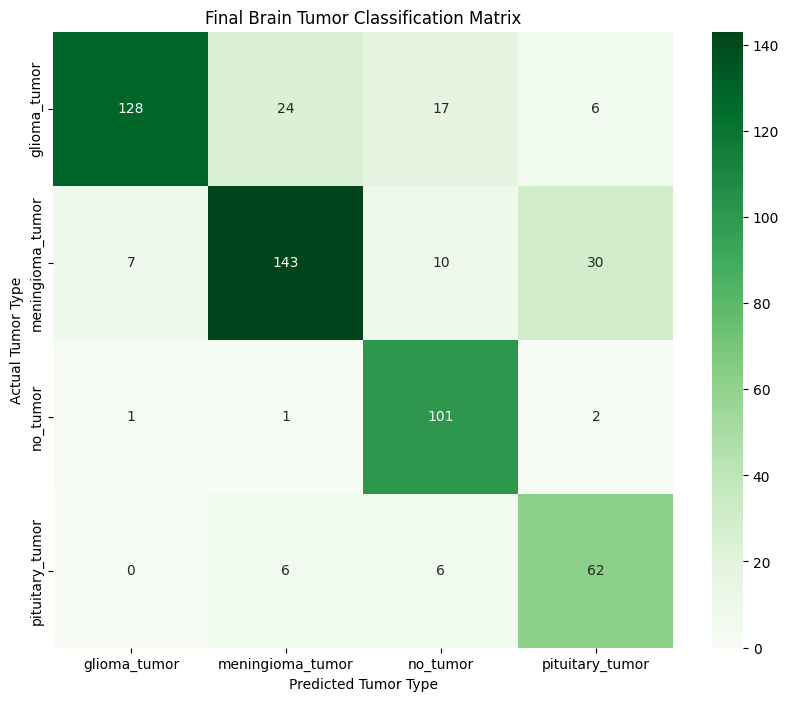

In [31]:

import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Gather all true labels and predictions
y_true = []
y_pred = []

for images, labels in val_ds:
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))

# 2. Print the text report
print("\n--- Medical Classification Report ---")
print(classification_report(y_true, y_pred, target_names=val_ds.class_names))

# 3. Plot a clean Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=val_ds.class_names,
            yticklabels=val_ds.class_names)
plt.title('Final Brain Tumor Classification Matrix')
plt.ylabel('Actual Tumor Type')
plt.xlabel('Predicted Tumor Type')
plt.show()

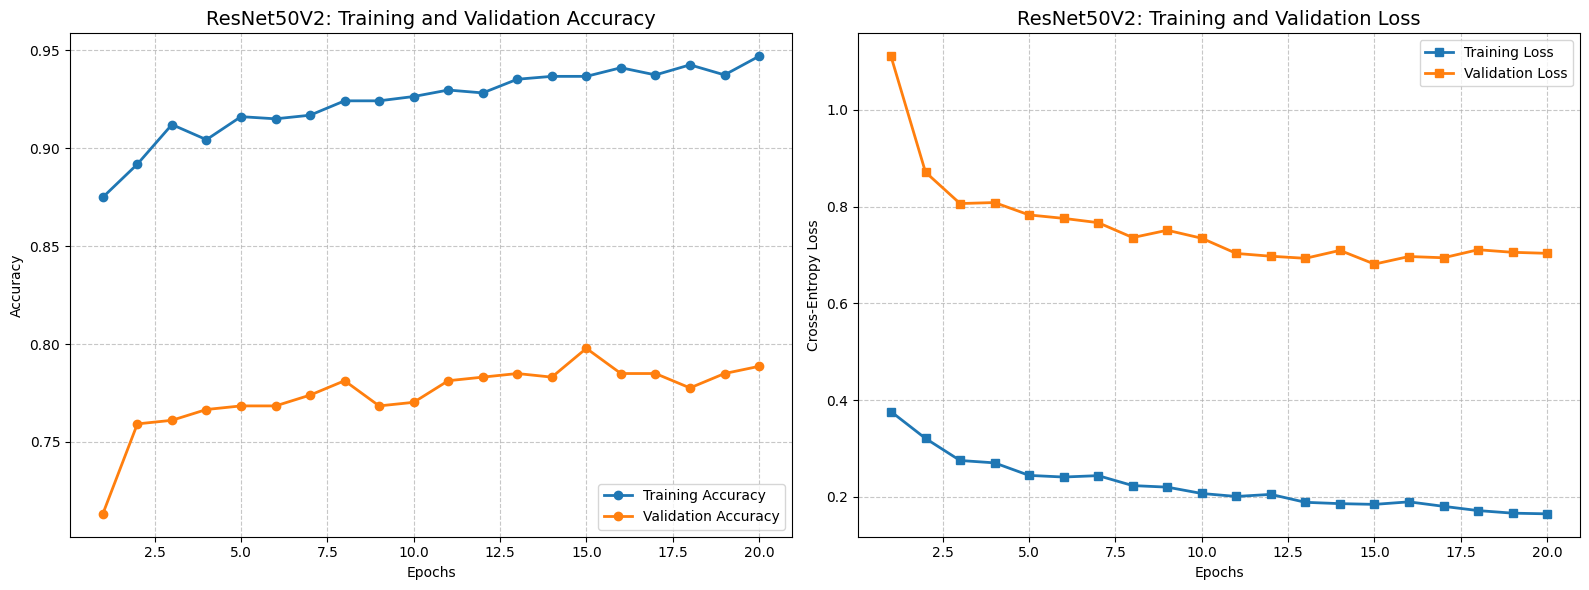

In [44]:
import matplotlib.pyplot as plt

def plot_medical_training_history(history):
    # Extract data from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(1, len(acc) + 1)

    # Create a clean, professional figure
    plt.figure(figsize=(16, 6))

    # --- Plot 1: Accuracy Over Time ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy', color='#1f77b4', marker='o', linewidth=2)
    plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='#ff7f0e', marker='o', linewidth=2)
    plt.title('ResNet50V2: Training and Validation Accuracy', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.7)

    # --- Plot 2: Loss Over Time ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss', color='#1f77b4', marker='s', linewidth=2)
    plt.plot(epochs_range, val_loss, label='Validation Loss', color='#ff7f0e', marker='s', linewidth=2)
    plt.title('ResNet50V2: Training and Validation Loss', fontsize=14)
    plt.xlabel('Epochs')
    plt.ylabel('Cross-Entropy Loss')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.tight_layout()
    plt.show()

# Call the function
plot_medical_training_history(history)